## 2022 Fall Phy 765 Advanced Quantum Mechanics Project #1
### Members: Michael Straus, Eren Guttentag, Jiyong Yu


In [2]:
import numpy as _np
import matplotlib.pyplot as _plt
import random
from time import process_time

## Class definition for worm algorithm simulation

In [3]:
###################################################### Define Grid location class ##########################################################################
class Grid_location(object):
    """
    An object for holding information about what is going on at each grid location
    """
    def __init__(self):
        self.is_particle = False # Whether or not there is a particle on that location.
        self.is_hardcore_boson_violated = False # Whether or not the hardcore boson constraint is violated
        
        """ Where_particle_came_from/is_going there are 2 numbers. The first is whether is moved in x(0)
        y(1) or z(2). The second (-1, 0, +1) is whether the previous/next position was 
        at the current coordinate, or +1 or -1 from it. 
        
        For example a trajector that goes (in Cartesian) (3,4,5) -> (3,5,5) -> (2,5,5) would have where_particle_came_from = [1, -1] and 
        where_particle_is_going = [0, -1] (It looks like we have to be careful with the sign!!)
        
        Note if the particle is stationary where_particle_came_from = [0, 0] or [1, 0] or [2, 0]. It doesn't matter
        """
        self.where_particle_came_from = [0, 0]
        self.where_particle_came_from_hardcore_boson_violated = [0, 0] # Specially used when hardcore boson constraint is violated
        self.where_particle_is_going = [0, 0]
    
    ### Set method ###
    def set_where_particle_came_from(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_came_from = [axis, direction]
    
    def set_where_particle_came_from_hardcore_boson_violated(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_came_from_hardcore_boson_violated = [axis, direction]
    
    def set_where_particle_is_going(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_is_going = [axis, direction]
    
    def set_is_hardcore_boson_violated(self, bool):
        self.is_hardcore_boson_violated = bool
    
    ### Get method ###
    def get_where_particle_came_from(self):
        return self.where_particle_came_from[0], self.where_particle_came_from[1]
    
    def get_where_particle_came_from_hardcore_boson_violated(self):
        return self.where_particle_came_from_hardcore_boson_violated[0], self.where_particle_came_from_hardcore_boson_violated[1]
    
    def get_where_particle_is_going(self):
        return self.where_particle_is_going[0], self.where_particle_is_going[1]
    
    def get_is_particle(self):
        return self.is_particle
    
    def get_is_hardcore_boson_violated(self):
        return self.is_hardcore_boson_violated
    
    #### Particle placement and removal setting ###
    def place_particle(self):
        self.is_particle = True
        
    def remove_particle(self):
        self.is_particle = False
    
###################################################### Define worm algorithm class ##########################################################################
class Worm_algorithm(object):
    """
    An object for holding information about the total worm algorithm
    """
    def __init__(self, parameters):
        #### Initial parameter setting ###
        # We set t = 1 for the all simulation parameters so that we can implement the dimensionless Hamiltonian
        self.N = parameters[0]
        self.mu = parameters[1]
        self.epsilon = parameters[2]
        self.beta = parameters[3]
        self.dimension = parameters[4]
        self.num_time_steps = int(self.beta / self.epsilon)
        
        #### Initial grid setting ###
        initial_grid = _np.full((self.N, self.N, self.N, self.num_time_steps), Grid_location()) # Initialization

        # If we use the above definition, all objects refer to the same memory address.
        # In this case, if we change one grid location, all grid locations are changed simultaneously
        # Therefore, we have to initialize the grid as below
        for x in range(self.N):
            for y in range(self.N):
                for z in range(self.N):
                    for t in range(self.num_time_steps):
                        initial_grid[x, y, z, t] = Grid_location()
        
        self.pathed_grid = initial_grid
        
        # Hopping weight setting
        self.p_move_forward = min(1, _np.exp(self.mu * self.epsilon))
        self.p_move_forward_hop = self.epsilon
        self.p_move_forward_straight = (1 - 2 * self.dimension * self.p_move_forward_hop)
        self.p_move_backward = min(1, _np.exp(-self.mu * self.epsilon))
        
        self.weight_no_hop = _np.exp(self.mu * self.epsilon) * self.p_move_forward_straight
        self.weight_hop = _np.exp(self.mu * self.epsilon) * self.p_move_forward_hop
    
    ### Set methods ###
    def set_pathed_grid(self, pathed_grid):
        self.pathed_grid = pathed_grid
    
    ### Get methods ###
    def get_N(self):
        return self.N
    
    def get_num_time_steps(self):
        return self.get_num_time_steps
    
    def get_pathed_grid(self):
        return self.pathed_grid
    
    ### Basic methods ###
    def unit_move_forward(self, loc, hop_axis, hop_direction, N, num_time_steps): # Temporal forward move
        new_loc = loc.copy()
        new_loc[hop_axis] = (loc[hop_axis] + hop_direction) % N # Periodic condition
        new_loc[3] = (loc[3] + 1) % (num_time_steps)
        
        return new_loc
    
    def unit_move_backward(self, loc, hop_axis, hop_direction, N, num_time_steps): # Temporal backward move
        new_loc = loc.copy()
        new_loc[hop_axis] = (loc[hop_axis] + hop_direction) % N # Periodic condition
        new_loc[3] = (loc[3] - 1) % (num_time_steps)
        
        return new_loc
    
    ### Algorithm & Simulation methods ###
    def measure_observables(self):
        """Count up the number of particles and number of hops which gives all information needed to compute
        the weight and energy of the path, then returns the number of particles, energy, and the weight of the path
        """
        
        pathed_grid = self.pathed_grid
        num_particles = 0 # Running total of number of particles
        num_hops = 0 # Running total of number of steps in which those particles hop spatially
        
        # Loop through the grid (need to make 2d or 1d version if needed?)
        for x in _np.arange(self.N):
            for y in _np.arange(self.N):
                for z in _np.arange(self.N):
                    # For each end location check if there is a path 
                    loc = [x, y, z, 0] # Start at the bottom of the grid and work forwards
                    time = loc[3]
                    
                    if pathed_grid[loc[0], loc[1], loc[2], loc[3]].get_is_particle():
                        num_particles += 1
                        #print('hi')
                        
                        # Go through the path
                        while time <= (self.num_time_steps - 1): # Should we include time = 0 or not?
                            current_grid_location = pathed_grid[tuple(loc)] # The grid_location object where we are in path
                            axis, direction = current_grid_location.get_where_particle_is_going()
                            
                            if direction != 0: # If this is 0, there is no spatial hopping
                                num_hops += 1
                                                        
                            # Update location to the previous step on the path
                            loc = self.unit_move_forward(loc, axis, direction, self.N, self.num_time_steps)
                            time = time + 1
        
        e_tilda = (2 * self.dimension * num_particles) - (num_hops / self.beta)
        weight = (self.weight_hop ** num_hops) * (self.weight_no_hop ** ((self.num_time_steps - 1) * num_particles - num_hops))
        return [num_particles, e_tilda, weight]

    def move_forward(self, loc, pathed_grid):
        """ This function updates the grid if the worm moves forward. It needs to do 3 things:
        1) choose a next location to go to
        2) update where_particle_is_going on the old location and where_particle_came_from on the new location
        3) deal with complications if there is already a particle at the location
        """
        
        facing_forward = True # Defines the final temporal direction after finishing the function
        
        #### Store the old & new location information first ####
        old_grid_location = pathed_grid[tuple(loc)]  
        new_loc = loc.copy() # Initialization
        
        #### Hopping ####
        if random.uniform(0, 1) < self.p_move_forward_straight:
            # Don't hop spatially, just move forward in time
            hop_axis, hop_direction = 0, 0
            new_loc = self.unit_move_forward(loc, hop_axis, hop_direction, self.N, self.num_time_steps)
            
        else:        
            # Hop both temporal and spatial at this time step
            hop_axis = random.randint(0, self.dimension - 1) # Get an integer 0 ~ 2 inclusive for the axis to move on (0: x, 1: y, 2: z)
            hop_direction = 2 * random.getrandbits(1) - 1 # For the direction, get +1 = 2 * 1 - 1 or -1 = 2 * 0 - 1
            
            new_loc = self.unit_move_forward(loc, hop_axis, hop_direction, self.N, self.num_time_steps)
            
            # Update the old location to say where it is going
            old_grid_location.set_where_particle_is_going(hop_axis, hop_direction)    
        
        #### Check the hardcore boson constraint ####
        new_grid_location = pathed_grid[tuple(new_loc)]
        
        if new_grid_location.is_particle:
            # Now in the condition of at a spot with two particles (hardcore boson constraint is violated)
            facing_forward = False # Now we have to move backward 
            new_grid_location.set_is_hardcore_boson_violated(True)
            
            # Save the information of original path
            original_axis, original_direction = new_grid_location.get_where_particle_came_from()
            
            new_grid_location.set_where_particle_came_from_hardcore_boson_violated(original_axis, original_direction)
            new_grid_location.set_where_particle_came_from(hop_axis, -hop_direction)
            
        else: 
            # If there is no particle at the new location, just update it
            new_grid_location.set_where_particle_came_from(hop_axis, -hop_direction)
            new_grid_location.place_particle()
            
        return new_loc, facing_forward

    def update_grid(self, pathed_grid):
        """
        Worm update algorithm goes here
        """
        # Pick initial site
        x0, y0, z0 = random.randrange(self.N), random.randrange(self.N), random.randrange(self.N)
        t0 = random.randrange(self.num_time_steps)
        loc0 = [x0, y0, z0, t0] # Original location
        
        # Initial up arrow if there is no particle
        facing_forward = not(pathed_grid[tuple(loc0)].is_particle)
        
        # Current location of the worm
        tail = loc0.copy()
        head = loc0.copy() # When copying the array, be careful with shallow & deep copy !!
        keep_going = True
        
        while keep_going:        
            #print(head)
            if facing_forward:
                if random.uniform(0, 1) <= self.p_move_forward: # Move forward proposal accepted
                    head, facing_forward = self.move_forward(head, pathed_grid)
                else:
                    facing_forward = False
                    
            else:
            #     For the case of the worm facing backwards     
            #     For facing backwards the steps are as follows
            #     1) go back one along the path, deleting the particle at the current location
            #     2) switch the arrow to something like facing forward, except the probabilities of adding a new step
            #       are different
                
                current_grid_location = pathed_grid[tuple(head)]
                
                # Hopping axis and direction setting (be careful with the hardcore boson violation condition)       
                if current_grid_location.get_is_hardcore_boson_violated() == True:
                    hop_back_axis, hop_back_direction = current_grid_location.get_where_particle_came_from_hardcore_boson_violated()

                else:
                    hop_back_axis, hop_back_direction = current_grid_location.get_where_particle_came_from()  
                
                # Particle removal (be careful with the hardcore boson violation condition)
                if current_grid_location.get_is_hardcore_boson_violated() == False: 
                    current_grid_location.remove_particle() # If it is the initial backward try, we should not remove the particle
                
                # Edge removal (be careful with the hardcore boson violation condition)
                if current_grid_location.get_is_hardcore_boson_violated() == True:
                    current_grid_location.set_where_particle_came_from_hardcore_boson_violated(0, 0) # Remove the spatial hopping edge
                    current_grid_location.set_is_hardcore_boson_violated(False)          
                else:
                    current_grid_location.set_where_particle_came_from(0, 0) 

                # Move back proposal
                head = self.unit_move_backward(head, hop_back_axis, hop_back_direction, self.N, self.num_time_steps)
                new_grid_location = pathed_grid[tuple(head)]
                new_grid_location.set_where_particle_is_going(0, 0) # Remove the spatial hopping edge
                
                # If the proposal is rejected, propose move forward again
                if random.uniform(0, 1) > self.p_move_backward:
                    head, facing_forward = self.move_forward(head, pathed_grid)
                
            # Now check whether we have arrive back at the place we started
            keep_going = (head != tail)
        
        return pathed_grid




## Real Monte Carlo Simulation and Plot Results

-----------------0 New grid created----------------------
-----------------5000 New grid created----------------------
-----------------10000 New grid created----------------------
-----------------15000 New grid created----------------------
-----------------20000 New grid created----------------------
-----------------25000 New grid created----------------------
-----------------30000 New grid created----------------------
-----------------35000 New grid created----------------------
-----------------40000 New grid created----------------------
-----------------45000 New grid created----------------------
-----------------50000 New grid created----------------------
-----------------55000 New grid created----------------------
-----------------60000 New grid created----------------------
-----------------65000 New grid created----------------------
-----------------70000 New grid created----------------------
-----------------75000 New grid created----------------------
-------------

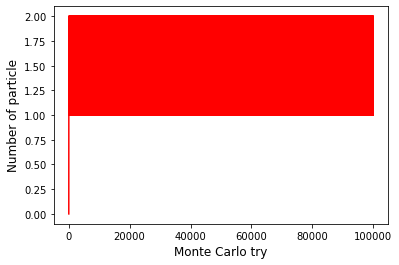

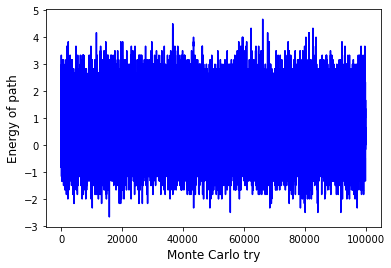

In [4]:
### Block making function ###
def block(array, N):
    # Device the given array into blocks with length N
    
    l = int(len(array) / N)
    
    blocked_array = _np.zeros([l, N])
    
    for i in range(0, l):
        block_start = i * N
        block_end = block_start + N
        
        blocked_array[i] = array[block_start: block_end]
        
    return blocked_array


### Parameter Setting ###
[N, mu, epsilon, beta, dimension] = [2, 1.4, 0.03, 12, 3]
parameters = [N, mu, epsilon, beta, dimension]

### Real simulation ###
# Worm algorithm class initialization
worm_algorithm = Worm_algorithm(parameters)

### Monte Carlo Simulation Trial ###
num_trials = 100000 # I think in one of the lectures, prof said we should expect this ot take ~1 million trials
ns = [] # Number of particles in each trial
cumavg_ns = []
es = [] # Energy of path in each trial
cumavg_es = []
Ws = [] # Weight of paths in each trial
cumavg_Ws = []

Frequency_Estimated = 1000
t1 = process_time()
w_cumavg = 0
n_cumavg = 0
e_cumavg = 0
for counter in range(num_trials):
    num_particles, e_tilda, weight = worm_algorithm.measure_observables()
    Ws.append(weight)
    w_cumavg = w_cumavg*counter/(counter+1)+weight/(counter+1)
    cumavg_Ws.append(w_cumavg)
    ns.append(num_particles)
    n_cumavg = n_cumavg*counter/(counter+1)+num_particles/(counter+1)
    cumavg_ns.append(n_cumavg)
    es.append(e_tilda)
    e_cumavg = e_cumavg*counter/(counter+1)+e_tilda/(counter+1)
    cumavg_es.append(e_cumavg)
    
    old_grid = worm_algorithm.get_pathed_grid()
    new_grid = worm_algorithm.update_grid(old_grid)
    worm_algorithm.set_pathed_grid(new_grid)
    
    #print('-----------------' + str(counter) + ' New grid created----------------------')
    if ((counter % 5000) == 0): print('-----------------' + str(counter) + ' New grid created----------------------')
    
### Plot the result ###
Monte_Carlo_try = range(num_trials)
_plt.rcParams['figure.facecolor'] = 'white'
_plt.plot(Monte_Carlo_try, ns, 'r')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Number of particle', fontsize = 12)

_plt.figure()
_plt.plot(Monte_Carlo_try, es, 'b')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Energy of path', fontsize = 12)

block_size = 50

ns_copy = ns
es_copy = es
ns = ns[2500:]
es = es[2500:]

cumavg_ns_copy = cumavg_ns
cumavg_es_copy = cumavg_es
cumavg_es = cumavg_es[2500:]
cumavg_ns = cumavg_ns[2500:]

ns_block = block(ns, block_size)
es_block = block(es, block_size)

print(_np.average(ns))
print(_np.average(es))


In [5]:
Monte_Carlo_try = range(num_trials)
emax = max(es_copy)
nmax = max(ns_copy)
n_end = cumavg_ns[-1]
e_end = cumavg_es[-1]

Text(40000.0, 1.0864500000000001, 'Final average value is 0.7243')

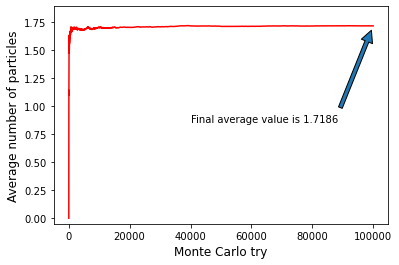

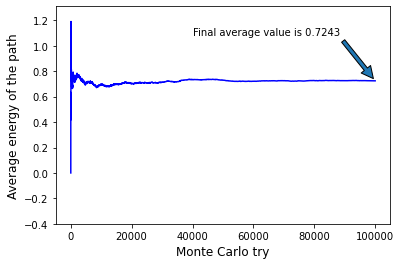

In [6]:

_plt.plot(Monte_Carlo_try, cumavg_ns_copy, 'r')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Average number of particles', fontsize = 12)
_plt.ylim([-0.05, max(cumavg_ns_copy)*1.1])
_plt.annotate('Final average value is '+str(round(n_end,4)), xy =(num_trials, round(n_end,4)),
                xytext =(0.4*num_trials, 0.5*round(n_end,4)), 
                arrowprops = dict(
                                  shrink = 0.05),)
_plt.figure()
_plt.plot(Monte_Carlo_try, cumavg_es_copy, 'b')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Average energy of the path', fontsize = 12)
_plt.ylim([-0.4, max(cumavg_es_copy)*1.1])
_plt.annotate('Final average value is '+str(round(e_end,4)), xy =(num_trials, round(e_end,4)),
                xytext =(0.4*num_trials, 1.5*round(e_end,4)), 
                arrowprops = dict(
                                  shrink = 0.05),)
